In [1]:
from utils import runwrite
import matplotlib.pyplot as plt

In [2]:
cd ../timegym/

/home/jovyan/work/timegym


# pipeline.py

by default, tests use split-test unless during optimization

use test(method='backtest', step='D') which simulate the passage of time, day by  in order to avoid look-ahead bias. 

we advise using modeling based on online learning or prequential learning. 

In [3]:
%%runwrite ../timegym/pipeline.py

from data.synthetic import basic_synthetics
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
from sktime.utils.validation._dependencies import _check_soft_dependencies
from sktime.utils.validation.forecasting import check_y
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import RecursiveRegressionForecaster
from sktime.forecasting.compose import DirectRegressionForecaster
#from sktime.forecasting.compose import MultioutputRegressionForecaster
from sklearn.pipeline import Pipeline as SkPipeline
from sktime.performance_metrics.forecasting import smape_loss
# other metrics: https://stats.stackexchange.com/questions/425390/how-do-i-decide-when-to-use-mape-smape-and-mase-for-time-series-analysis-on-sto
import types
from sklearn.base import TransformerMixin, RegressorMixin, BaseEstimator
from collections import defaultdict
from sktime.forecasting.naive import NaiveForecaster
import inspect
from tqdm.auto import tqdm
#from pqdm.threads import pqdm
#from pqdm.processes import pqdm
import seaborn as sns


class FunctionTransformation(BaseEstimator, TransformerMixin):
    def __init__(self, transformation, **hyperparameters):
        self.transformation = transformation
        self.hyperparameters = hyperparameters

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.transformation(X, **self.hyperparameters)
    
    
class Pipeline(BaseEstimator, TransformerMixin):
    
    def __init__(self, strategy='recursive', window_length=100):
        """
        """
        self.strategy = strategy
        self.window_length = window_length
        self.steps = []
    
    
    def sample_hyperparameters(search_space: dict):
        raise NotImplementedError
        #for hyperparameter in search_space:
            
        
    
    def add(self, transformation, append=False, **hyperparameters):
        """Adds one transformation step to the pipeline
        
        Parameters
        ----------
        transformation : sklearn.base.TransformerMixin, function
            One transformation class, or a function.
        **hyperparamters : string, int, float, optuna.suggestion, optional (default=None)
            other hyperparameters to be initialized  of series, will be displayed in figure legend
        Returns
        -------
        fig : plt.Figure
        ax : plt.Axis
        """
        if hyperparameters:
            for h in hyperparameters:
                if isinstance(hyperparameters[h], tuple):
                    #TODO: use optuna to generate these hyperparameters dymically if requested by user
                    raise NotImplementedError
        
        if inspect.isfunction(transformation):
            transformation = FunctionTransformation(partial(transformation, **hyperparameters))
        elif inspect.isclass(transformation):
            transformation = transformation(**hyperparameters)
            if isinstance(transformation, BaseEstimator):
                pass
            elif not isinstance(transformation, TransformerMixin):
                raise NotImplementedError
                #transformation = FunctionTransformation(transformations)
            
        self.steps.append(transformation)
        
    
    def predict(self, y_train, y_test):
        # TODO: add support for time series regression
        #DirectTimeSeriesRegressionForecaster
        #RecursiveTimeSeriesRegressionForecaster
        
        if isinstance(self.steps[-1], RegressorMixin):
            # convert pipeline steps to a sklearn pipeline
            pipeline = SkPipeline([(type(step).__name__, step) for step in self.steps])
    
            # create the forecaster according to one of the following strategies: 
            # 'recursive' (default), 'direct', 'combination', 'multioutput'
            if self.strategy=='recursive':
                forecaster = RecursiveRegressionForecaster(pipeline, window_length=self.window_length)
            elif self.strategy=='direct': 
                forecaster = DirectRegressionForecaster(pipeline)
            elif self.strategy=='combination':
                raise NotImplementedError 
            elif self.strategy=='multioutput':
                #forecaster = MultioutputRegressionForecaster(pipeline)
                #better code still yet to come
                raise NotImplementedError
        else: #ASSUME THAT LAST STEP IS A FORECASTER
            # convert pipeline steps to a sklearn pipeline (except for the last step
            pipeline = SkPipeline([(type(step).__name__, step) for step in self.steps[:-1]])
            y_train = pipeline.fit_transform(y_train)
            forecaster = self.steps[-1]
                
        forecaster = forecaster.fit(y_train)
        y_pred = forecaster.predict(ForecastingHorizon(y_test.index, is_relative=False))
        return y_pred
    
    def plot_tests(self, datasets=basic_synthetics, tests_per_dataset=3, naive=None):
        """
        plot_tests plots a matrix plot of forecasts including the ideal 'oracle' values.
        
        Parameters
        ----------
        datasets : list of datasets, optional (default=timegym.synthetic.basic_synthetics)
            List of datasets used for the tests.
            
        tests_per_dataset : int, optional (default=3)
            Number of tests generated per dataset.
            
        naive : str{"last", "mean", "drift"}, optional (default=None)
            Naive strategy used to make forecasts:
            * "last" : forecast the last value in the
                        training series when sp is 1.
                        When sp is not 1,
                        last value of each season
                        in the last window will be
                        forecasted for each season.
            * "mean" : forecast the mean of last window
                         of training series when sp is 1.
                         When sp is not 1, mean of all values
                         in a season from last window will be
                         forecasted for each season.
            * "drift": forecast by fitting a line between the
                        first and last point of the window and
                         extrapolating it into the future
        """
        self.__forecaster = self.steps[-1]
        
        fig, axes = plt.subplots(nrows=len(datasets), ncols=tests_per_dataset, 
                                 figsize=(tests_per_dataset*10,len(datasets)*5),
                                 squeeze=False)

        for d, dataset in enumerate(datasets):
            axes[d, 0].set_ylabel(dataset.shortname)
            for t in range(tests_per_dataset):
                # training and test
                y_train, y_test, oracle = dataset.get_data()
                y_pred = self.predict(y_train, y_test)
                smape_pred = smape_loss(oracle[y_test.index], y_pred) # pred vs oracle
                smape_noise = smape_loss(oracle[y_test.index], y_test) # noisy-signal vs oracle 
                pd.Series(oracle).plot(ax=axes[d, t], color='gray', label='Oracle (noiseless signal)', legend=True, linewidth=1)
                pd.Series(pd.concat([y_train, y_test])).plot(ax=axes[d, t], color='gray', label='Observations (sMAPE: {:.3f})'.format(smape_noise), legend=True, marker='.', markersize=2, linewidth=0)
                pd.Series(y_pred).plot(ax=axes[d, t], color='blue', label='Predictions (sMAPE: {:.3f})'.format(smape_pred), legend=True, marker='x', markersize=1.5, linewidth=0)
                if naive:
                    naive_forecaster = NaiveForecaster(strategy=naive).fit(y_train)
                    y_pred_naive = naive_forecaster.predict(ForecastingHorizon(y_test.index, is_relative=False))
                    smape_naive = smape_loss(oracle[y_test.index], y_pred_naive) # naive vs oracle
                    pd.Series(y_pred_naive).plot(ax=axes[d, t], color='green', label='Naive (sMAPE: {:.3f})'.format(smape_naive), legend=True, marker='.', markersize=1, linewidth=0)
                split_date = y_train.index[-1] + (y_test.index[0] - y_train.index[-1])/2
                axes[d, t].axvline(split_date, color='blue', linewidth=2, linestyle='--')
                axes[d, t].set_xlim(xmin=oracle.index[0], xmax=oracle.index[-1])
                axes[d, t].legend(loc='upper left')
        return fig
    
    
    def plot_error(self, datasets=basic_synthetics, tests_per_dataset=100, n_jobs=4):
        # TODO (dataset=['synthetic', 'stocks'], metrics=['CRPS', 'sum-logreturn', 'etc']
        self.__forecaster = self.steps[-1]
        
        fig, ax = plt.subplots(nrows=len(datasets), ncols=1, squeeze=False,
                                 figsize=(12, len(datasets)*5))
        
        def prediction_smape(d):
            y_train, y_test, oracle = datasets[d].get_data()
            y_pred = self.predict(y_train, y_test)
            return smape_loss(oracle[y_test.index], y_pred)

        tests_datasets_indices = list(range(len(datasets))) * tests_per_dataset
        results = []
        for d in tqdm(tests_datasets_indices):
            results.append(prediction_smape(d))
        results = pd.Series(results, index=tests_datasets_indices)
        
        # plot results
        for d in range(len(datasets)):
            sns.histplot(results.loc[d], ax=ax[d, 0], kde=True, stat='count', bins=tests_per_dataset//5)
            ax[d, 0].set
        return fig
    

## Tests

In [4]:
!pip install xgboost --quiet

transformations

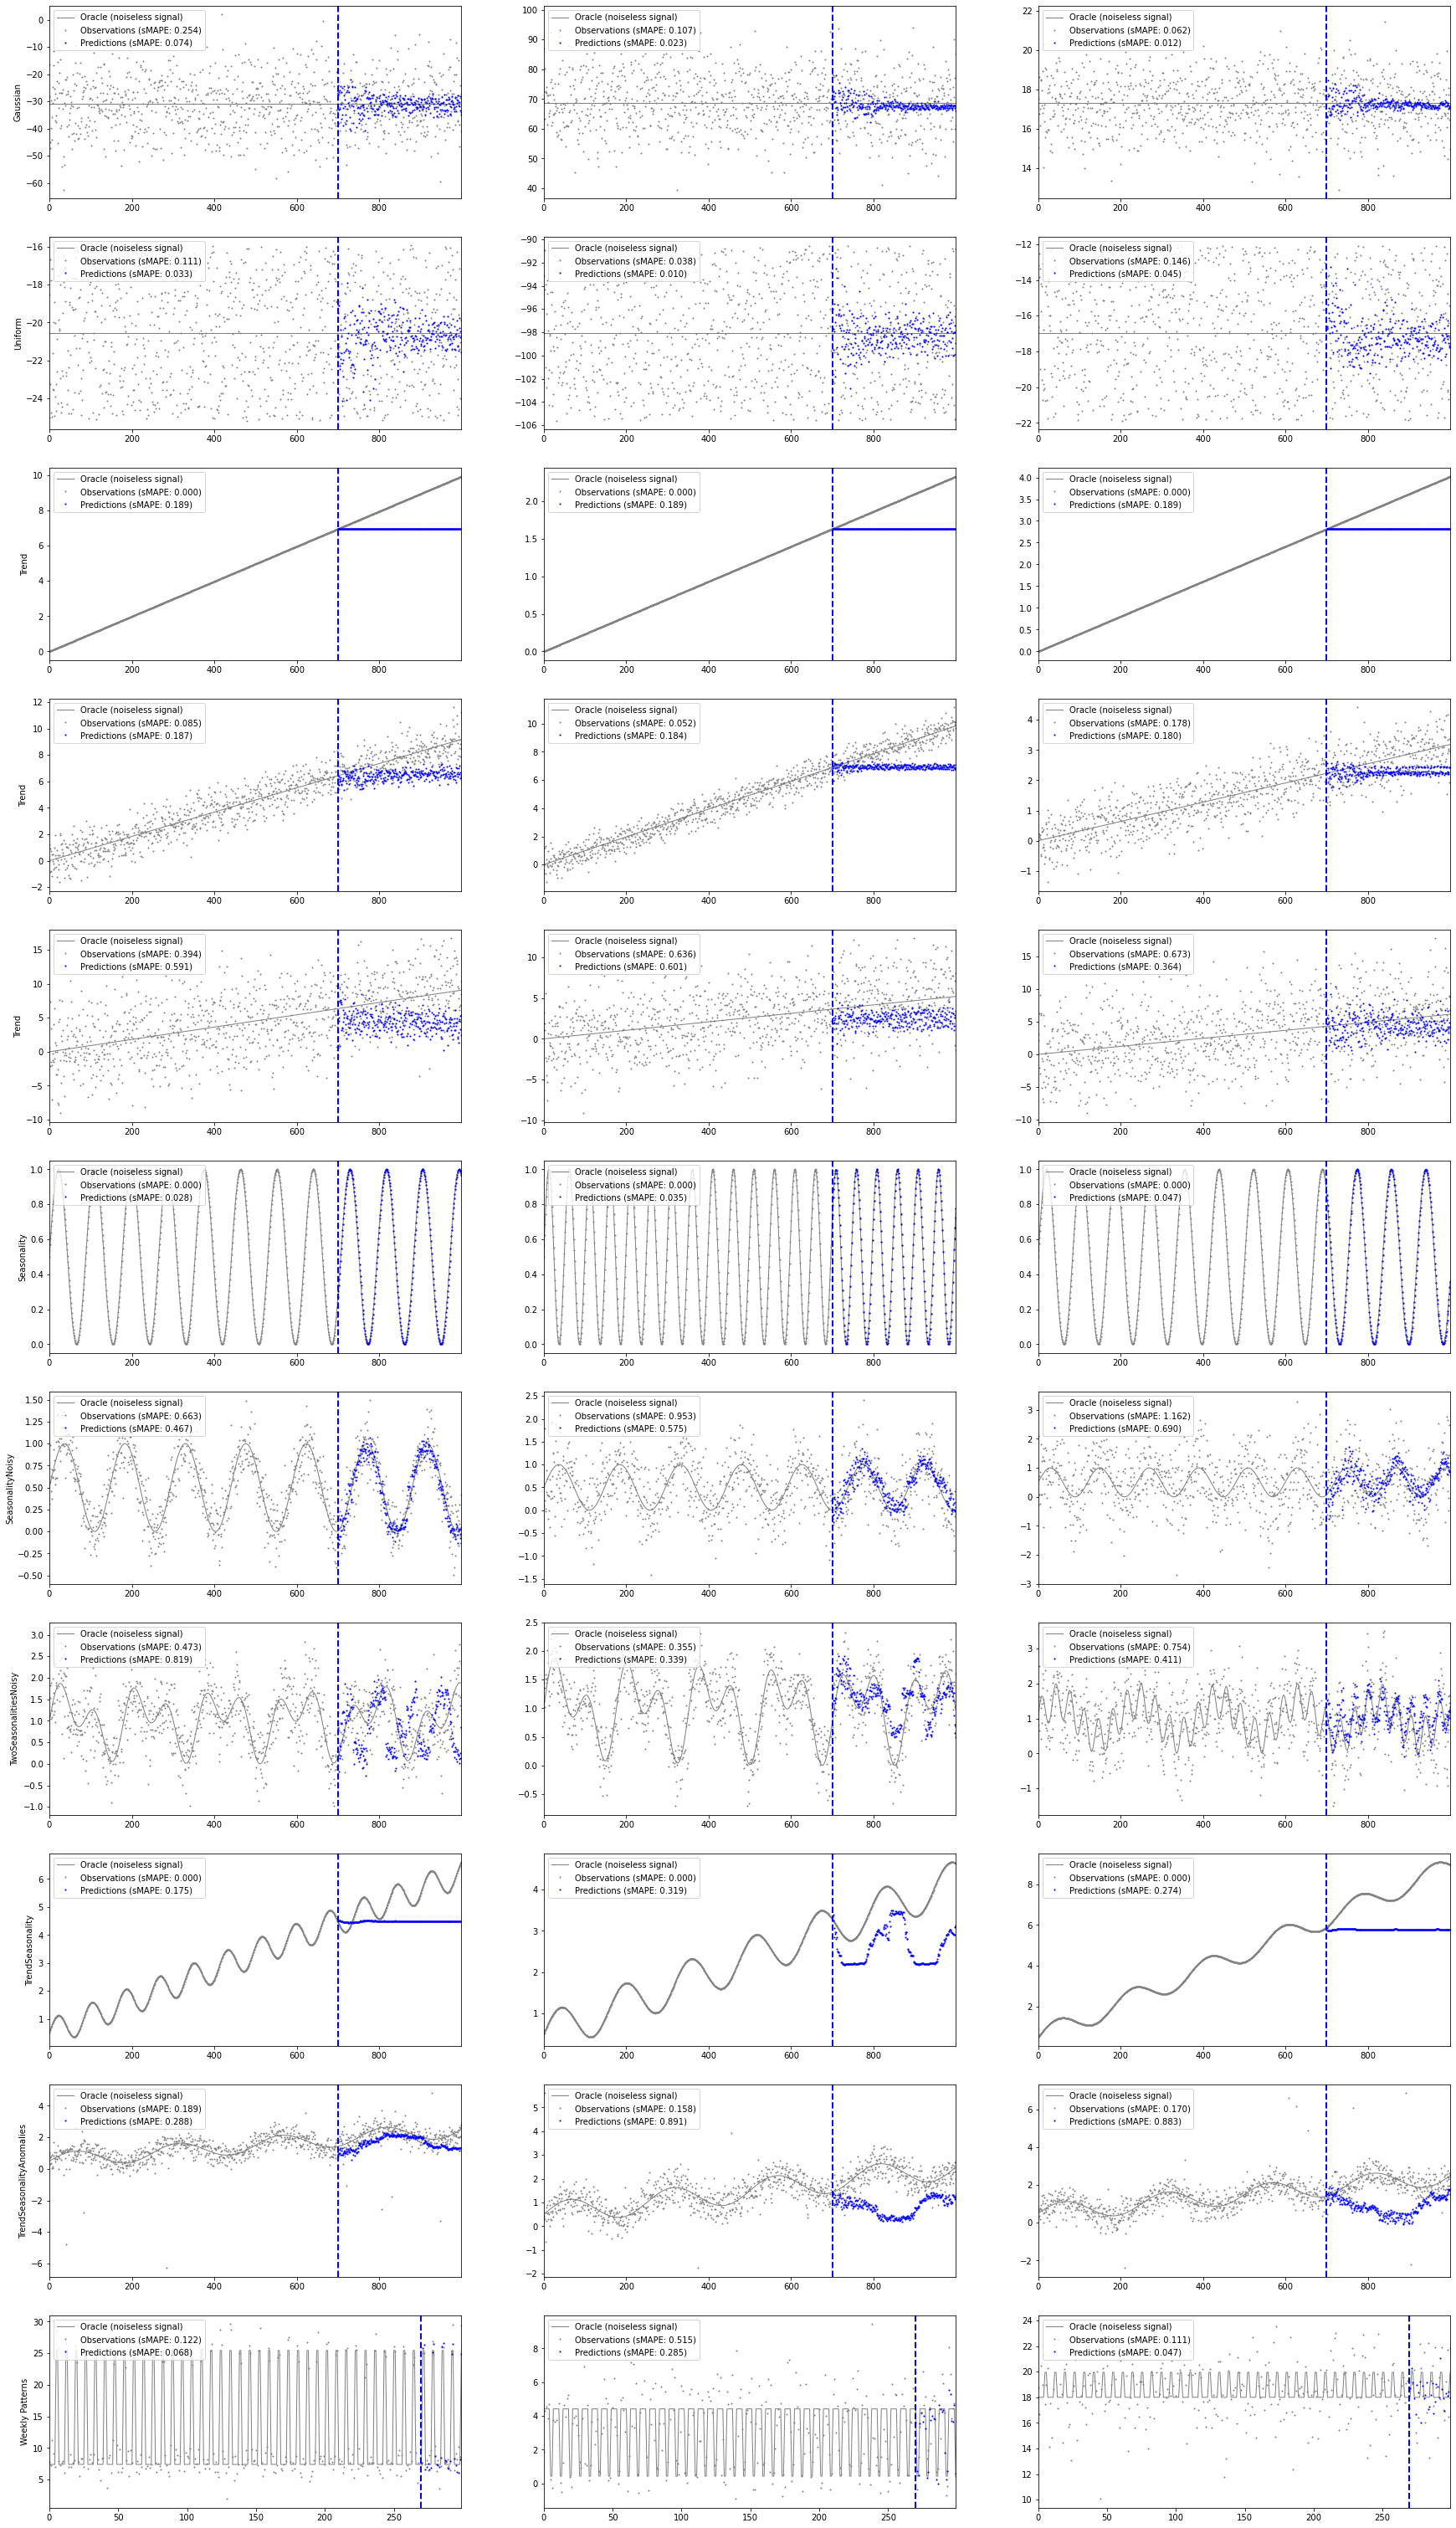

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

pipeline = Pipeline()
pipeline.add(lambda x: print(x.shape))
pipeline.add(StandardScaler())
pipeline.add(PCA(0.95))
pipeline.add(AutoRegressiveStrategy(horizon_length=100, horizon_step=2)) # or MultiOutputStrategy(horizon_length=100) or DirectStrategy(horizon_length=100, horizon_step=) or CerqueiraArbitrage
pipeline.add(XGBRegressor()) # by default, the very last step of the pipeline is the modelling process
pipeline.plot_tests(); # TODO output line by line as it calculates
# TODO show criteria for failing / passing test? did it pass it?

In [ ]:
# TODO: show error plots (if more error, the redder it gets near the top)

  0%|          | 0/1100 [00:00<?, ?it/s]

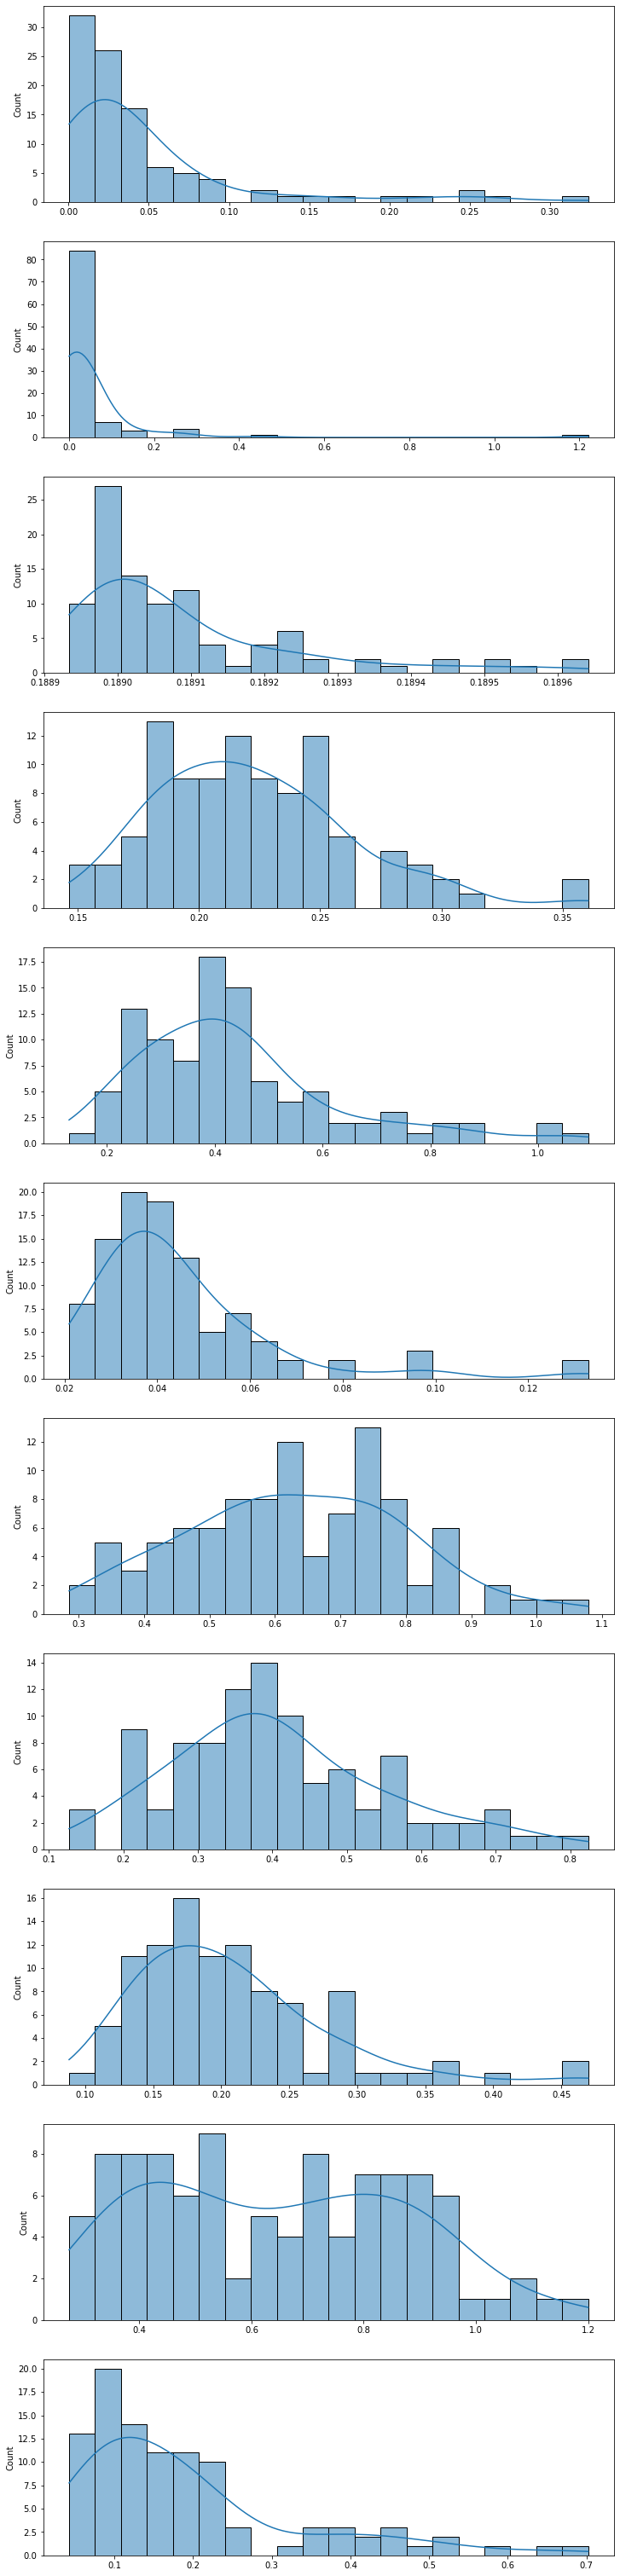

In [8]:
# TODO improve plot labels (what is the Y-axis? what is X-axis?)
# TODO: show predicted VS actual 2d plot
# TODO: how does the error change according to some features? (e.g. is it dependant on the month?)
pipeline.plot_error();

In [ ]:
# TODO error distribution over time
# TODO Running this command does 3 things: shows a timeplot / a spectroplot with the time period sampled, 
# the window analysed, the prediction by time, the actual value by time, and the error distribution by time. 
# Moreover, this produces a file with the tests performed (one per hyperparameter optimization).

## Using probabilistic forecasting

Evaluate each model forecast CRPS

[https://www.lokad.com/continuous-ranked-probability-score](https://www.lokad.com/continuous-ranked-probability-score)

[properscoring](https://pypi.org/project/properscoring/)

this is a nice package to use for calculating the 

how to get CRPS (weightedQuantileLoss) in gluonts:

[https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/](https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/)

[Zamo-Naveau2018_Article_EstimationOfTheContinuousRanke.pdf](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/8b01e8ef-3812-4635-8d4a-94f897eab90e/Zamo-Naveau2018_Article_EstimationOfTheContinuousRanke.pdf)

literature on CRPS

[https://hal.archives-ouvertes.fr/hal-02121796/document](https://hal.archives-ouvertes.fr/hal-02121796/document)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from timegym.optimization import optimize

pipeline = Pipeline()
pipeline.add(lagged_target, maxlags=optimize(0, 300))
pipeline.add(time_features)
pipeline.add(seasonal_features)
pipeline.add(StandardScaler)
pipeline.add(GaussianProcessRegressor, alpha=optimize(0.01, 10., log=True))
pipeline.debug(data='synthetic');

In [ ]:
pipeline.debug(data='stocks'); # random samples 10 stocks (one per line) in 3 distinct time periods (one per columns)

In [ ]:
pipeline.optimize(data='synthetic', method='optuna', metric='CRPS', horizon='1Y') # metric = MAE, RMSE, CRPS, MAE + L1 penalty
#pipeline.optimize(data='stocks', until='2011', method='optuna', metric='CRPS', horizon='1Y')
pipeline.debugging(data='stocks'); # random samples 10 stocks (one per line) in 3 distinct time periods (one per columns)

In [ ]:
pipeline.forecast(data='stocks:IBM', start='2011', metric='CRPS', horizon='1Y'); # a probabilistic forecasting plot, with CRPS, with residuals, with 2d actual vs pred

In [ ]:
def eval_options_trade(options_table, pipeline, start='2011', horizon='1Y', trades=10):
    # rank options contracts in terms of predicted profit
    # select best 10 contracts to trade from options_table
    # evaluate profit after closing trades
    return total_profit or avg_return

In [ ]:
# https://catboost.ai/docs/concepts/loss-functions-regression.html

In [28]:
# TODO: have training also include auto-optuna (or normalizing flow) on hyperparamters optimization (GP) for timesteps t+1..t+h

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomMovingAverages(BaseEstimator, TransformerMixin):
    # this transformer takes a 2d array or a dataframe, and calculates moving averages of the first column
    
    def __init__(self, periods=[]):
        self.periods = periods
    
    def fit(self, X, y=None):
        pass

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for period in self.periods:
            X['MA'+str(period)] = X.iloc[:,0].rolling(period).mean()
        return X
    

IndentationError: expected an indented block (<ipython-input-14-50725fe2c7da>, line 11)

In [ ]:
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor

pipeline = TabularRegressionPipeline()
pipeline.add(QuantileTransformer())
pipeline.add(XGBRegressor())
pipeline.test();

In [ ]:
from sktime.forecasting.arima import AutoARIMA

pipeline = Pipeline()
pipeline.add(AutoARIMA(sp=100, suppress_warnings=True))
pipeline.test();

In [ ]:
from sktime.forecasting.ets import AutoETS

pipeline = Pipeline()
pipeline = AutoETS(auto=True, sp=12, n_jobs=-1)
pipeline.test();

In [ ]:
# TODO compatible with gluonts models?

In [ ]:
class NewFeatureEngineeringF:
    
    def fit(self, X, y=None):
        self.mean = x.mean()
        self.std = x.std()
    
    def transform(self, X):
        return (x-self.mean())/self.std()
        